In [ ]:
# IMPORTACIÓN DE LIBRERÍAS NECESARIAS PARA EL PROYECTO

# Librerías para manipulación de datos y cálculos numéricos
import numpy as np                    # Operaciones matemáticas y arrays
import pandas as pd                   # Manipulación de datos tabulares

# Librerías de PyTorch para redes neuronales
import torch                          # Framework de deep learning
from torch import nn                  # Módulos de redes neuronales
from torch.utils.data import DataLoader, Dataset  # Manejo de datos para entrenamiento

# Librerías para visualización y fechas
import matplotlib.pyplot as plt       # Creación de gráficas
import datetime as dt                 # Manejo de fechas y tiempo

# Librerías de scikit-learn para preprocesamiento
from sklearn.preprocessing import StandardScaler  # Normalización de datos

# Configuración para ocultar advertencias no críticas
import warnings
warnings.filterwarnings('ignore')

print("Librerías importadas correctamente")
print("Objetivo: Predicción temporal de temperatura Beijing con features estacionales")

Librerías importadas correctamente
Objetivo: Predicción temporal de temperatura Beijing con features estacionales


In [ ]:
# 1. CARGA Y PREPROCESAMIENTO DE DATOS

# Cargar el dataset de calidad del aire de Beijing
df = pd.read_csv("BEIJIN.csv")
# Eliminar filas donde la temperatura esté vacía (crítico para nuestro target)
df = df.dropna(subset=['TEMP'])
# Convertir la columna de temperatura a tipo float para cálculos numéricos
df['TEMP'] = df['TEMP'].astype(float)

print(f"Dataset original: {len(df)} registros")

# Limitar el dataset a 20,000 registros para hacer el entrenamiento más rápido
# Tomamos los últimos registros para tener datos más recientes
if len(df) > 20000:
    df = df.tail(20000).reset_index(drop=True)
    print(f"Reducido a: {len(df)} registros")

# CREACIÓN DE FEATURES TEMPORALES (CRÍTICO PARA EVITAR PREDICCIONES CONSTANTES)
# Crear una secuencia de fechas artificiales empezando desde 2010
start_date = pd.Timestamp('2010-01-01')
df['date'] = pd.date_range(start=start_date, periods=len(df), freq='D')
# Extraer el día del año (1-365) y el mes (1-12)
df['day_of_year'] = df['date'].dt.dayofyear
df['month'] = df['date'].dt.month

# FEATURES CÍCLICAS PARA CAPTURAR ESTACIONALIDAD
# Convertir el tiempo en características cíclicas usando funciones trigonométricas
# Esto permite al modelo entender que diciembre (12) está cerca de enero (1)
df['day_sin'] = np.sin(2 * np.pi * df['day_of_year'] / 365.25)  # Patrón anual en seno
df['day_cos'] = np.cos(2 * np.pi * df['day_of_year'] / 365.25)  # Patrón anual en coseno
df['month_sin'] = np.sin(2 * np.pi * df['month'] / 12)          # Patrón mensual en seno
df['month_cos'] = np.cos(2 * np.pi * df['month'] / 12)          # Patrón mensual en coseno

# VARIABLES ADICIONALES DEL AMBIENTE
# Buscar variables meteorológicas adicionales que puedan influir en la temperatura
additional_features = []
for var in ['PM2.5', 'PRES', 'DEWP']:  # PM2.5=contaminación, PRES=presión, DEWP=punto de rocío
    if var in df.columns:
        # Convertir a numérico y rellenar valores faltantes con la mediana
        df[var] = pd.to_numeric(df[var], errors='coerce').fillna(df[var].median())
        additional_features.append(var)

print(f"Features adicionales: {additional_features}")

# CONFIGURACIÓN DE LA VARIABLE OBJETIVO
y = df['TEMP'].values  # Array de temperaturas (variable que queremos predecir)
W = 30  # Ventana temporal de 30 días (cuántos días pasados usar para predecir)

print(f"Estadísticas TEMP: mean={y.mean():.2f}, std={y.std():.2f}")
print(f"Ventana temporal: {W} días")

Dataset original: 43824 registros
Reducido a: 20000 registros
Features adicionales: ['PRES', 'DEWP']
Estadísticas TEMP: mean=12.11, std=11.89
Ventana temporal: 30 días


In [ ]:
# 2. CONSTRUCCIÓN DE LA MATRIZ DE CARACTERÍSTICAS

# FUNCIÓN PARA CREAR MATRIX DE LAGS (VALORES PASADOS)
def build_lag_matrix(y_array, window):
    """
    Crea una matriz donde cada fila contiene los últimos 'window' valores
    Para predecir el día t, usamos los días [t-30, t-29, ..., t-1]
    """
    X_lags = []
    # Comenzamos desde 'window' porque necesitamos tener suficientes valores pasados
    for t in range(window, len(y_array)):
        # Tomamos los últimos 'window' valores y los invertimos
        # [::-1] invierte el orden para que el más reciente esté al final
        X_lags.append(y_array[t-window:t][::-1])
    return np.array(X_lags)

# CONSTRUCCIÓN DE LAGS TEMPORALES
# Cada fila tendrá 30 valores de temperatura de los días anteriores
X_lags = build_lag_matrix(y, W)

# CONSTRUCCIÓN DE FEATURES TEMPORALES
# Para cada momento temporal, extraemos las características estacionales
temporal_features = []
feature_names = ['day_sin', 'day_cos', 'month_sin', 'month_cos']
for t in range(W, len(df)):  # Empezamos desde W porque perdemos los primeros W días
    # Extraemos las 4 características temporales para el momento t
    temp_feats = [df[feat].iloc[t] for feat in feature_names]
    temporal_features.append(temp_feats)

X_temporal = np.array(temporal_features)

# CONSTRUCCIÓN DE VARIABLES ADICIONALES
# Agregamos las variables meteorológicas si están disponibles
X_additional = []
if additional_features:  # Si tenemos PM2.5, PRES, DEWP
    for t in range(W, len(df)):
        add_feats = []
        for col in additional_features:
            # Convertir a numérico, si falla usar 0.0
            val = pd.to_numeric(df[col].iloc[t], errors='coerce')
            add_feats.append(val if not pd.isna(val) else 0.0)
        X_additional.append(add_feats)
    X_additional = np.array(X_additional)
    # Combinar todas las características: lags + temporales + adicionales
    X = np.hstack([X_lags, X_temporal, X_additional])
else:
    # Solo combinar lags + temporales
    X = np.hstack([X_lags, X_temporal])

# VARIABLE OBJETIVO AJUSTADA
# Como perdimos los primeros W días en X, también ajustamos y
y_target = y[W:]

# LIMPIEZA DE DATOS
# Reemplazar cualquier NaN o infinito con 0
X = np.nan_to_num(X)
y_target = np.nan_to_num(y_target)

print(f"Matriz de features: {X.shape}")  # (muestras, características)
print(f"Target vector: {y_target.shape}")  # (muestras,)

# 3. DIVISIÓN DE DATOS Y NORMALIZACIÓN

# Calcular el número total de muestras
N = len(y_target)
# División 80% entrenamiento, 20% validación (manteniendo orden temporal)
X_train, X_val = X[:int(N*0.8)], X[int(N*0.8):]
y_train, y_val = y_target[:int(N*0.8)], y_target[int(N*0.8):]

# NORMALIZACIÓN DE CARACTERÍSTICAS (StandardScaler)
# Transformar para que tengan media=0 y desviación=1
scaler_X = StandardScaler()
X_train_norm = scaler_X.fit_transform(X_train)  # Ajustar y transformar entrenamiento
X_val_norm = scaler_X.transform(X_val)          # Solo transformar validación

# NORMALIZACIÓN DE VARIABLE OBJETIVO
# También normalizamos la temperatura para ayudar al entrenamiento
scaler_y = StandardScaler()
y_train_norm = scaler_y.fit_transform(y_train.reshape(-1, 1)).reshape(-1)
y_val_norm = scaler_y.transform(y_val.reshape(-1, 1)).reshape(-1)

print(f"Train: {len(X_train)} muestras")
print(f"Val: {len(X_val)} muestras")
print(f"Features por muestra: {X_train.shape[1]}")

Matriz de features: (19970, 36)
Target vector: (19970,)
Train: 15976 muestras
Val: 3994 muestras
Features por muestra: 36


In [ ]:
# 4. CONFIGURACIÓN DE DATASET Y MODELO

# CLASE DATASET PERSONALIZADA PARA PYTORCH
class TempDataset(Dataset):
    """
    Clase que convierte nuestros datos numpy a formato PyTorch
    Permite cargar datos en lotes (batches) durante el entrenamiento
    """
    def __init__(self, X, Y):
        # Convertir arrays numpy a tensores PyTorch con tipo float
        self.X = torch.from_numpy(X).float()
        # Reshapear Y para que sea columna (necesario para PyTorch)
        self.Y = torch.from_numpy(Y).float().view(-1, 1)
    
    def __len__(self):
        # Retorna el número total de muestras
        return len(self.X)
    
    def __getitem__(self, ix):
        # Retorna una muestra específica (características y objetivo)
        return self.X[ix], self.Y[ix]

# CREACIÓN DE DATASETS
# Diccionario que contiene los datasets de entrenamiento y validación
dataset = {
    'train': TempDataset(X_train_norm, y_train_norm),
    'val': TempDataset(X_val_norm, y_val_norm)
}

# CREACIÓN DE DATALOADERS
# Los DataLoaders manejan la carga de datos en lotes durante el entrenamiento
dataloader = {
    'train': DataLoader(dataset['train'], batch_size=32, shuffle=True),   # Entrenamiento: lotes de 32, mezclados
    'val': DataLoader(dataset['val'], batch_size=1000, shuffle=False)     # Validación: lotes grandes, sin mezclar
}

# 5. DEFINICIÓN DEL MODELO DE RED NEURONAL
def build_model(D_in, H=64, D_out=1, dropout=0.2):
    """
    Construye una red neuronal feedforward con dropout
    D_in: número de características de entrada
    H: número de neuronas en capas ocultas
    D_out: número de salidas (1 para regresión)
    dropout: probabilidad de dropout para regularización
    """
    return nn.Sequential(
        nn.Linear(D_in, H),    # Capa lineal: entrada -> 64 neuronas
        nn.ReLU(),             # Función de activación ReLU
        nn.Dropout(dropout),   # Dropout para prevenir overfitting
        nn.Linear(H, H),       # Capa oculta: 64 -> 64 neuronas  
        nn.ReLU(),             # Activación ReLU
        nn.Dropout(dropout),   # Dropout
        nn.Linear(H, D_out)    # Capa de salida: 64 -> 1 neurona (temperatura)
    )

# 6. FUNCIÓN DE EVALUACIÓN DEL MODELO
def evaluate_model(model, dataloader, scaler_y):
    """
    Evalúa el modelo en el conjunto de validación
    Calcula métricas: MAE, MSE, precisión
    Retorna predicciones desnormalizadas
    """
    model.eval()  # Poner modelo en modo evaluación (desactiva dropout)
    y_pred_norm = []  # Lista para guardar predicciones normalizadas
    
    # Desactivar cálculo de gradientes para evaluación
    with torch.no_grad():
        # Procesar cada lote del conjunto de validación
        for x_b, _ in dataloader['val']:
            y_pred = model(x_b)  # Hacer predicción
            # Convertir tensor a numpy y aplanar
            y_pred_norm.append(y_pred.numpy().reshape(-1))
    
    # Concatenar todas las predicciones
    y_pred_norm = np.concatenate(y_pred_norm)
    # Desnormalizar predicciones para obtener temperaturas reales
    y_pred_real = scaler_y.inverse_transform(y_pred_norm.reshape(-1, 1)).reshape(-1)
    
    # CÁLCULO DE MÉTRICAS
    mae = np.mean(np.abs(y_val - y_pred_real))              # Error absoluto medio
    mse = np.mean((y_val - y_pred_real)**2)                 # Error cuadrático medio
    precision = (1 - mae / np.abs(y_val.mean())) * 100     # Precisión como porcentaje
    
    return {'mae': mae, 'mse': mse, 'precision': precision, 'predictions': y_pred_real}

print(f"Modelo configurado: {X_train.shape[1]} -> 64 -> 64 -> 1")
print("Dataset y DataLoader preparados")

Modelo configurado: 36 -> 64 -> 64 -> 1
Dataset y DataLoader preparados


In [ ]:
# 7. FUNCIÓN DE ENTRENAMIENTO CON EARLY STOPPING

def fit_model(model, optimizer, dataloader, epochs=100, patience=10, name=""):
    """
    Entrena el modelo con early stopping para prevenir overfitting
    
    Parámetros:
    - model: modelo de red neuronal a entrenar
    - optimizer: optimizador (SGD, Adam, etc.)
    - dataloader: diccionario con datos de entrenamiento y validación
    - epochs: número máximo de épocas
    - patience: cuántas épocas esperar sin mejora antes de parar
    - name: nombre del optimizador para logs
    """
    # Función de pérdida: Error Cuadrático Medio
    criterion = nn.MSELoss()
    
    # Listas para guardar el historial de pérdidas
    train_losses, val_losses = [], []
    
    # Variables para early stopping
    best_val_loss = float('inf')  # Mejor pérdida de validación encontrada
    patience_counter = 0          # Contador de épocas sin mejora
    
    # BUCLE PRINCIPAL DE ENTRENAMIENTO
    for epoch in range(1, epochs + 1):
        
        # FASE DE ENTRENAMIENTO
        model.train()  # Activar modo entrenamiento (activa dropout)
        batch_losses = []  # Pérdidas de cada lote
        
        # Procesar cada lote de entrenamiento
        for x_b, y_b in dataloader['train']:
            y_pred = model(x_b)           # Predicción del modelo
            loss = criterion(y_pred, y_b) # Calcular pérdida
            
            # BACKPROPAGATION
            optimizer.zero_grad()  # Limpiar gradientes anteriores
            loss.backward()        # Calcular gradientes
            optimizer.step()       # Actualizar pesos
            
            batch_losses.append(loss.item())  # Guardar pérdida del lote
        
        # Promedio de pérdida de entrenamiento en esta época
        train_losses.append(np.mean(batch_losses))
        
        # FASE DE VALIDACIÓN
        model.eval()  # Modo evaluación (desactiva dropout)
        val_batch_losses = []
        
        # Procesar validación sin calcular gradientes
        with torch.no_grad():
            for x_b, y_b in dataloader['val']:
                y_pred = model(x_b)
                loss = criterion(y_pred, y_b)
                val_batch_losses.append(loss.item())
        
        # Promedio de pérdida de validación en esta época
        val_losses.append(np.mean(val_batch_losses))
        
        # EARLY STOPPING LOGIC
        if val_losses[-1] < best_val_loss:
            # Si mejoramos, actualizar mejor pérdida y resetear contador
            best_val_loss = val_losses[-1]
            patience_counter = 0
        else:
            # Si no mejoramos, incrementar contador
            patience_counter += 1
            
        # Si no hay mejora por 'patience' épocas, detener entrenamiento
        if patience_counter >= patience:
            print(f"{name} Early stopping at epoch {epoch}")
            break
            
        # LOGGING: mostrar progreso cada 20 épocas
        if epoch % 20 == 0:
            print(f"{name} Epoch {epoch} | train_loss: {train_losses[-1]:.6f} | val_loss: {val_losses[-1]:.6f}")
    
    # Retornar historial de entrenamiento
    return {
        'train_loss': train_losses,
        'val_loss': val_losses,
        'epochs': len(train_losses)
    }

In [ ]:
# 8. ENTRENAMIENTO CON OPTIMIZADOR SGD

print("Entrenando SGD...")

# CREAR MODELO
# Número de características de entrada = columnas de X_train
# Dropout = 0.3 (30% de neuronas se desactivan aleatoriamente)
model = build_model(X_train.shape[1], dropout=0.3)

# CONFIGURAR OPTIMIZADOR SGD
# lr = 0.001: tasa de aprendizaje (qué tan grandes son los pasos)
# momentum = 0.9: ayuda a acelerar en direcciones consistentes
optimizer = torch.optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

# ENTRENAR EL MODELO
# epochs=100: máximo 100 épocas
# early stopping se activará automáticamente si no mejora en 10 épocas
history = fit_model(model, optimizer, dataloader, epochs=100, name="SGD")

# EVALUAR MODELO ENTRENADO
# Obtener métricas en conjunto de validación
result = evaluate_model(model, dataloader, scaler_y)

# GUARDAR REFERENCIAS AL MEJOR MODELO
# Como solo tenemos SGD por ahora, este es el "mejor"
best_model = model
best_result = result

# MOSTRAR RESULTADOS
print(f"SGD - MAE: {result['mae']:.4f}°C | Precision: {result['precision']:.1f}%")

Entrenando SGD...
SGD Epoch 20 | train_loss: 0.046155 | val_loss: 0.015525
SGD Epoch 40 | train_loss: 0.040270 | val_loss: 0.014439
SGD Early stopping at epoch 52
SGD - MAE: 1.1220°C | Precision: 92.0%


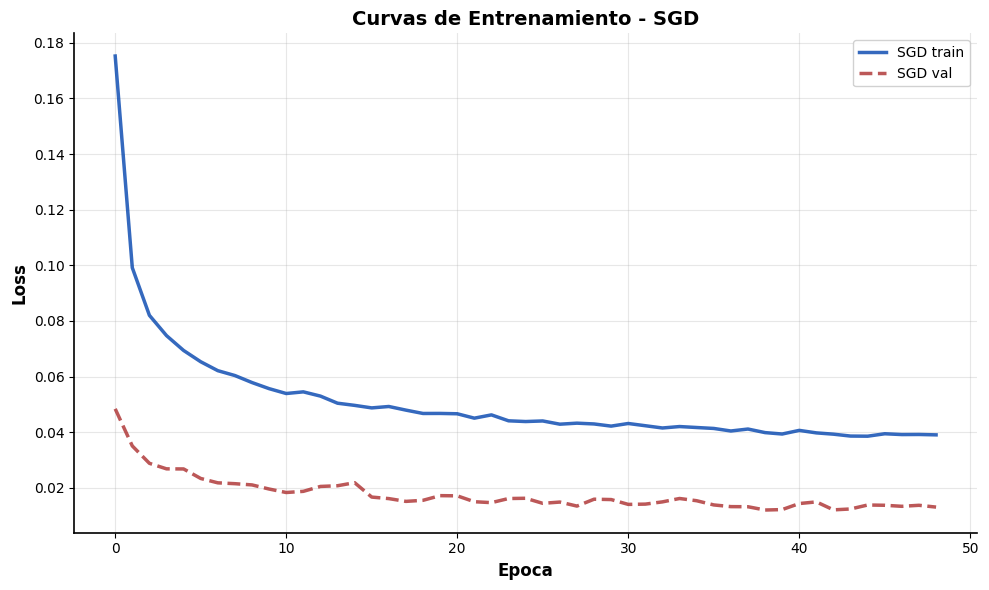

In [ ]:
# 8.1. VISUALIZACIÓN DE CURVAS DE ENTRENAMIENTO - SGD

# CREAR FIGURA Y EJES
fig, ax = plt.subplots(1, 1, figsize=(10, 6))

# GRAFICAR CURVAS DE PÉRDIDA
# Línea sólida azul para pérdida de entrenamiento
ax.plot(history['train_loss'], label='SGD train', 
        color="#0244AE", linewidth=2.5, alpha=0.8)
# Línea punteada roja para pérdida de validación
ax.plot(history['val_loss'], label='SGD val', 
        color="#AB2E2E", linestyle='--', linewidth=2.5, alpha=0.8)

# CONFIGURACIÓN DE LA GRÁFICA
ax.set_title('Curvas de Entrenamiento - SGD', 
             fontsize=14, fontweight='bold')
ax.set_xlabel('Epoca', fontsize=12, fontweight='bold')
ax.set_ylabel('Loss', fontsize=12, fontweight='bold')
ax.legend(fontsize=10, framealpha=0.9)  # Leyenda con transparencia
ax.grid(True, alpha=0.3, linewidth=0.8)  # Cuadrícula suave

# ESTILO PROFESIONAL
# Quitar bordes superiores y derechos para apariencia limpia
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
# Hacer bordes izquierdo e inferior más gruesos
ax.spines['left'].set_linewidth(1.2)
ax.spines['bottom'].set_linewidth(1.2)

plt.tight_layout()  # Ajustar espaciado automáticamente
plt.show()

In [ ]:
# 9. PREDICCIÓN PARA LOS PRÓXIMOS 30 DÍAS

# FUNCIÓN PARA GENERAR CARACTERÍSTICAS TEMPORALES FUTURAS
def future_temporal_features(start_date, steps):
    """
    Genera características temporales para fechas futuras
    Calcula seno y coseno para capturar patrones estacionales
    """
    dates = []     # Lista de fechas futuras
    features = []  # Lista de características temporales
    current_date = start_date  # Empezar desde la última fecha conocida
    
    # Generar características para cada día futuro
    for _ in range(steps):
        # Avanzar un día
        current_date = current_date + dt.timedelta(days=1)
        dates.append(current_date)
        
        # Extraer información temporal
        doy = current_date.timetuple().tm_yday  # Día del año (1-365)
        month = current_date.month               # Mes (1-12)
        
        # CONVERTIR A CARACTERÍSTICAS CÍCLICAS
        # Usar seno y coseno para que el modelo entienda que dic(12) está cerca de ene(1)
        day_sin = np.sin(2 * np.pi * doy / 365.25)    # Patrón anual en seno
        day_cos = np.cos(2 * np.pi * doy / 365.25)    # Patrón anual en coseno
        month_sin = np.sin(2 * np.pi * month / 12)    # Patrón mensual en seno
        month_cos = np.cos(2 * np.pi * month / 12)    # Patrón mensual en coseno
        
        features.append([day_sin, day_cos, month_sin, month_cos])
    
    return dates, np.array(features)

# CONFIGURACIÓN DE PREDICCIÓN
FORECAST_STEPS = 30  # Predecir próximos 30 días

# PREPARAR DATOS INICIALES
# Tomar últimos 30 días de temperatura real como punto de partida
last_window_y = y[-W:].astype(float).copy()
# Obtener última fecha del dataset
start_date = df['date'].iloc[-1].to_pydatetime()

# GENERAR CARACTERÍSTICAS TEMPORALES FUTURAS
future_dates, future_temporal = future_temporal_features(start_date, FORECAST_STEPS)

# PREPARAR CARACTERÍSTICAS ADICIONALES PARA EL FUTURO
if additional_features:  # Si tenemos PM2.5, PRES, DEWP
    # Crear matriz para valores futuros
    future_additional = np.zeros((FORECAST_STEPS, len(additional_features)))
    # Asumir que las variables ambientales se mantienen constantes
    # (Simplificación: usar último valor conocido)
    for i, feat in enumerate(additional_features):
        future_additional[:, i] = df[feat].iloc[-1]
else:
    # Si no hay variables adicionales, crear matriz vacía
    future_additional = np.zeros((FORECAST_STEPS, 0))

# CONFIGURAR MODELO PARA PREDICCIÓN
best_model.eval()  # Modo evaluación (desactivar dropout)
predictions_30_days = []  # Lista para guardar predicciones
window = last_window_y.copy()  # Ventana deslizante de 30 días

print("Predicción iterativa de 30 días...")
print("-" * 40)

# PREDICCIÓN ITERATIVA DÍA POR DÍA
for day in range(FORECAST_STEPS):
    
    # PREPARAR INPUT PARA EL MODELO
    # Tomar últimos 30 valores de la ventana (lags)
    lags = window[-W:]
    # Obtener características temporales para este día específico
    temporal_feats = future_temporal[day]
    
    # COMBINAR TODAS LAS CARACTERÍSTICAS
    if future_additional.shape[1] > 0:  # Si hay variables adicionales
        additional_feats = future_additional[day]
        # Concatenar: lags + temporales + adicionales
        x_input = np.hstack([lags, temporal_feats, additional_feats])
    else:
        # Solo concatenar: lags + temporales
        x_input = np.hstack([lags, temporal_feats])
    
    # NORMALIZAR INPUT
    # Usar el mismo scaler del entrenamiento para mantener consistencia
    x_input_norm = scaler_X.transform(x_input.reshape(1, -1))[0]
    # Convertir a tensor PyTorch
    x_tensor = torch.tensor(x_input_norm, dtype=torch.float32).unsqueeze(0)
    
    # HACER PREDICCIÓN
    with torch.no_grad():  # No calcular gradientes (solo predicción)
        y_pred_norm = best_model(x_tensor).numpy().reshape(-1)[0]
    
    # DESNORMALIZAR PREDICCIÓN
    # Convertir de valor normalizado a temperatura real
    y_pred = scaler_y.inverse_transform([[y_pred_norm]])[0][0]
    
    # GUARDAR PREDICCIÓN Y ACTUALIZAR VENTANA
    predictions_30_days.append(y_pred)
    # Agregar predicción a la ventana deslizante para próxima iteración
    window = np.append(window, y_pred)
    
    # Mostrar progreso
    print(f"Día {day+1:2d}: {y_pred:.2f}°C")

# Convertir lista a array numpy
predictions_30_days = np.array(predictions_30_days)

Predicción iterativa de 30 días...
----------------------------------------
Día  1: 3.55°C
Día  2: 5.47°C
Día  3: 4.25°C
Día  4: 3.06°C
Día  5: 0.47°C
Día  6: -1.29°C
Día  7: -1.94°C
Día  8: -1.15°C
Día  9: 0.07°C
Día 10: 0.35°C
Día 11: -0.48°C
Día 12: -1.18°C
Día 13: -2.44°C
Día 14: -3.18°C
Día 15: -2.95°C
Día 16: -2.03°C
Día 17: -1.21°C
Día 18: -0.86°C
Día 19: 0.77°C
Día 20: 1.16°C
Día 21: 1.04°C
Día 22: 0.62°C
Día 23: -0.23°C
Día 24: -0.87°C
Día 25: -1.60°C
Día 26: -1.92°C
Día 27: -2.26°C
Día 28: -2.35°C
Día 29: -1.80°C
Día 30: 0.35°C



Métricas finales:
MAE: 1.0543°C
Precisión: 92.5%
Último valor real: -3.00°C
Primera predicción: 3.55°C


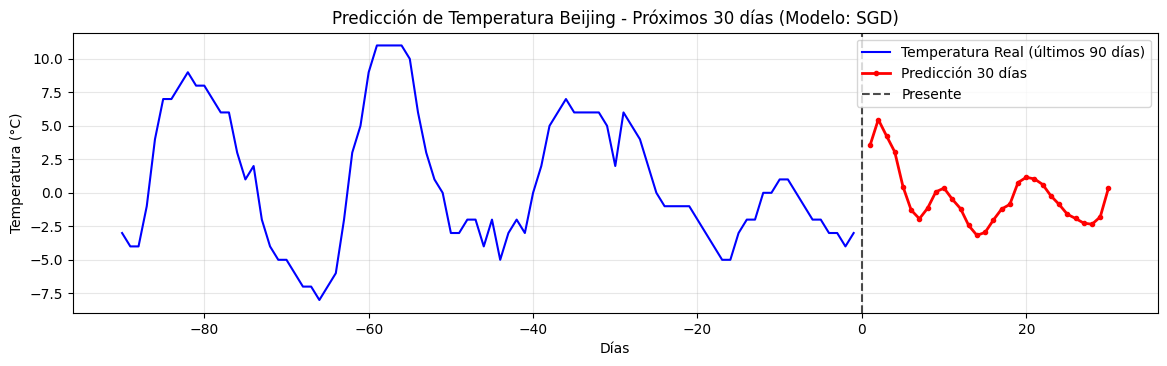

In [ ]:
# 10. VISUALIZACIÓN FINAL SGD

# CREAR FIGURA PARA MOSTRAR RESULTADOS
plt.figure(figsize=(14, 8))
plt.subplot(2, 1, 1)  # Primera sub-gráfica

# CONFIGURAR DATOS PARA VISUALIZACIÓN
context_days = 90  # Mostrar últimos 90 días históricos para contexto
historical_temp = y[-context_days:]  # Temperaturas históricas
# Crear índices negativos para datos históricos (-90, -89, ..., -1, 0)
historical_indices = np.arange(-context_days, 0)
# Crear índices positivos para predicciones (1, 2, ..., 30)
prediction_indices = np.arange(1, FORECAST_STEPS + 1)

# GRAFICAR DATOS
# Línea azul: temperaturas reales históricas
plt.plot(historical_indices, historical_temp, 'b-', 
         label='Temperatura Real (últimos 90 días)', linewidth=1.5)
# Línea roja con marcadores: predicciones SGD
plt.plot(prediction_indices, predictions_30_days, 'r-', 
         label='Predicción SGD 30 días', linewidth=2, marker='o', markersize=3)
# Línea vertical negra: marca el "presente" (separación pasado/futuro)
plt.axvline(x=0, color='black', linestyle='--', alpha=0.7, label='Presente')

# CONFIGURACIÓN DE GRÁFICA
plt.xlabel('Días')
plt.ylabel('Temperatura (°C)')
plt.title('Predicción de Temperatura Beijing - SGD')
plt.legend()
plt.grid(True, alpha=0.3)  # Cuadrícula suave

# MOSTRAR MÉTRICAS FINALES
print("\nMétricas SGD:")
print(f"MAE: {best_result['mae']:.4f}°C")                    # Error absoluto medio
print(f"Precisión: {best_result['precision']:.1f}%")         # Precisión porcentual
print(f"Último valor real: {y[-1]:.2f}°C")                  # Última temperatura conocida
print(f"Primera predicción: {predictions_30_days[0]:.2f}°C") # Primera predicción futura

## ----------------------ADAM-----------------------

In [ ]:
# 11. ENTRENAMIENTO CON OPTIMIZADOR ADAM (COMPARACIÓN)

print("\nEntrenando Adam...")

# CREAR NUEVO MODELO PARA ADAM
# Importante: crear modelo independiente para comparación justa
model_adam = build_model(X_train.shape[1], dropout=0.3)

# CONFIGURAR OPTIMIZADOR ADAM
# Adam es un optimizador adaptativo que ajusta automáticamente la tasa de aprendizaje
# lr = 0.001: misma tasa base que SGD para comparación justa
optimizer_adam = torch.optim.Adam(model_adam.parameters(), lr=0.001)

# ENTRENAR MODELO CON ADAM
# Mismos parámetros que SGD: 100 épocas máximo, early stopping en 10 épocas
history_adam = fit_model(model_adam, optimizer_adam, dataloader, epochs=100, name="Adam")

# EVALUAR MODELO ADAM
# Calcular métricas en conjunto de validación
result_adam = evaluate_model(model_adam, dataloader, scaler_y)

# MOSTRAR RESULTADOS ADAM
print(f"Adam - MAE: {result_adam['mae']:.4f}°C | Precision: {result_adam['precision']:.1f}%")


Entrenando Adam...
Adam Epoch 20 | train_loss: 0.033156 | val_loss: 0.014233
Adam Early stopping at epoch 27
Adam - MAE: 0.9235°C | Precision: 93.4%


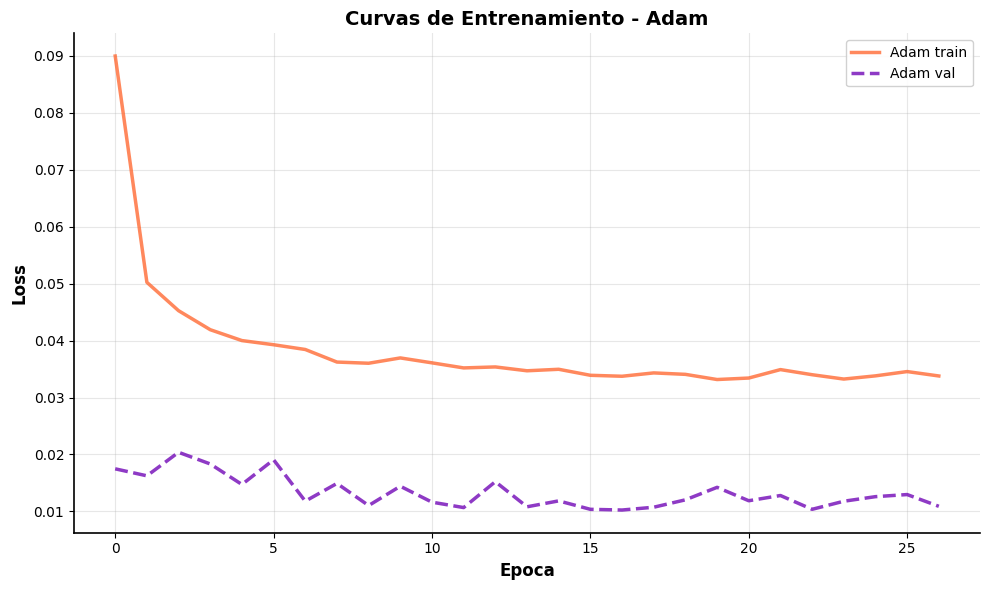

In [ ]:
# 12. VISUALIZACIÓN CURVAS DE ENTRENAMIENTO - ADAM

# CREAR FIGURA PARA CURVAS DE ADAM
fig, ax = plt.subplots(1, 1, figsize=(10, 6))

# GRAFICAR CURVAS DE PÉRDIDA ADAM
# Colores distintivos para diferenciarlo de SGD
# Línea naranja sólida para entrenamiento
ax.plot(history_adam['train_loss'], label='Adam train', 
        color="#FF6B35", linewidth=2.5, alpha=0.8)
# Línea morada punteada para validación
ax.plot(history_adam['val_loss'], label='Adam val', 
        color="#7209B7", linestyle='--', linewidth=2.5, alpha=0.8)

# CONFIGURACIÓN DE GRÁFICA
ax.set_title('Curvas de Entrenamiento - Adam', 
             fontsize=14, fontweight='bold')
ax.set_xlabel('Epoca', fontsize=12, fontweight='bold')
ax.set_ylabel('Loss', fontsize=12, fontweight='bold')
ax.legend(fontsize=10, framealpha=0.9)
ax.grid(True, alpha=0.3, linewidth=0.8)

# APLICAR ESTILO PROFESIONAL
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_linewidth(1.2)
ax.spines['bottom'].set_linewidth(1.2)

plt.tight_layout()
plt.show()

In [ ]:
# 13. PREDICCIÓN 30 DÍAS CON ADAM

# CONFIGURAR MODELO ADAM PARA PREDICCIÓN
model_adam.eval()  # Modo evaluación
predictions_30_days_adam = []  # Lista para predicciones Adam
window_adam = last_window_y.copy()  # Ventana deslizante independiente para Adam

print("Predicción iterativa Adam - 30 días...")
print("-" * 40)

# PREDICCIÓN ITERATIVA CON MODELO ADAM
# Proceso idéntico al SGD pero usando el modelo entrenado con Adam
for day in range(FORECAST_STEPS):
    
    # PREPARAR INPUT
    lags = window_adam[-W:]  # Últimos 30 valores de la ventana Adam
    temporal_feats = future_temporal[day]  # Características temporales para este día
    
    # COMBINAR CARACTERÍSTICAS
    if future_additional.shape[1] > 0:
        additional_feats = future_additional[day]
        x_input = np.hstack([lags, temporal_feats, additional_feats])
    else:
        x_input = np.hstack([lags, temporal_feats])
    
    # NORMALIZAR Y CONVERTIR A TENSOR
    x_input_norm = scaler_X.transform(x_input.reshape(1, -1))[0]
    x_tensor = torch.tensor(x_input_norm, dtype=torch.float32).unsqueeze(0)
    
    # PREDICCIÓN CON MODELO ADAM
    with torch.no_grad():
        y_pred_norm = model_adam(x_tensor).numpy().reshape(-1)[0]
    
    # DESNORMALIZAR Y GUARDAR
    y_pred = scaler_y.inverse_transform([[y_pred_norm]])[0][0]
    predictions_30_days_adam.append(y_pred)
    # Actualizar ventana Adam independientemente
    window_adam = np.append(window_adam, y_pred)
    
    print(f"Día {day+1:2d}: {y_pred:.2f}°C")

# Convertir a array numpy
predictions_30_days_adam = np.array(predictions_30_days_adam)

Predicción iterativa Adam - 30 días...
----------------------------------------
Día  1: 2.78°C
Día  2: 5.60°C
Día  3: 4.76°C
Día  4: 3.65°C
Día  5: 1.67°C
Día  6: -0.62°C
Día  7: -1.66°C
Día  8: -1.26°C
Día  9: -0.40°C
Día 10: 0.13°C
Día 11: -0.42°C
Día 12: -1.34°C
Día 13: -2.71°C
Día 14: -3.64°C
Día 15: -3.32°C
Día 16: -1.80°C
Día 17: -1.17°C
Día 18: -1.05°C
Día 19: 0.25°C
Día 20: 0.36°C
Día 21: 1.05°C
Día 22: 0.85°C
Día 23: 0.23°C
Día 24: -0.49°C
Día 25: -1.37°C
Día 26: -1.93°C
Día 27: -2.83°C
Día 28: -3.04°C
Día 29: -3.09°C
Día 30: -0.90°C


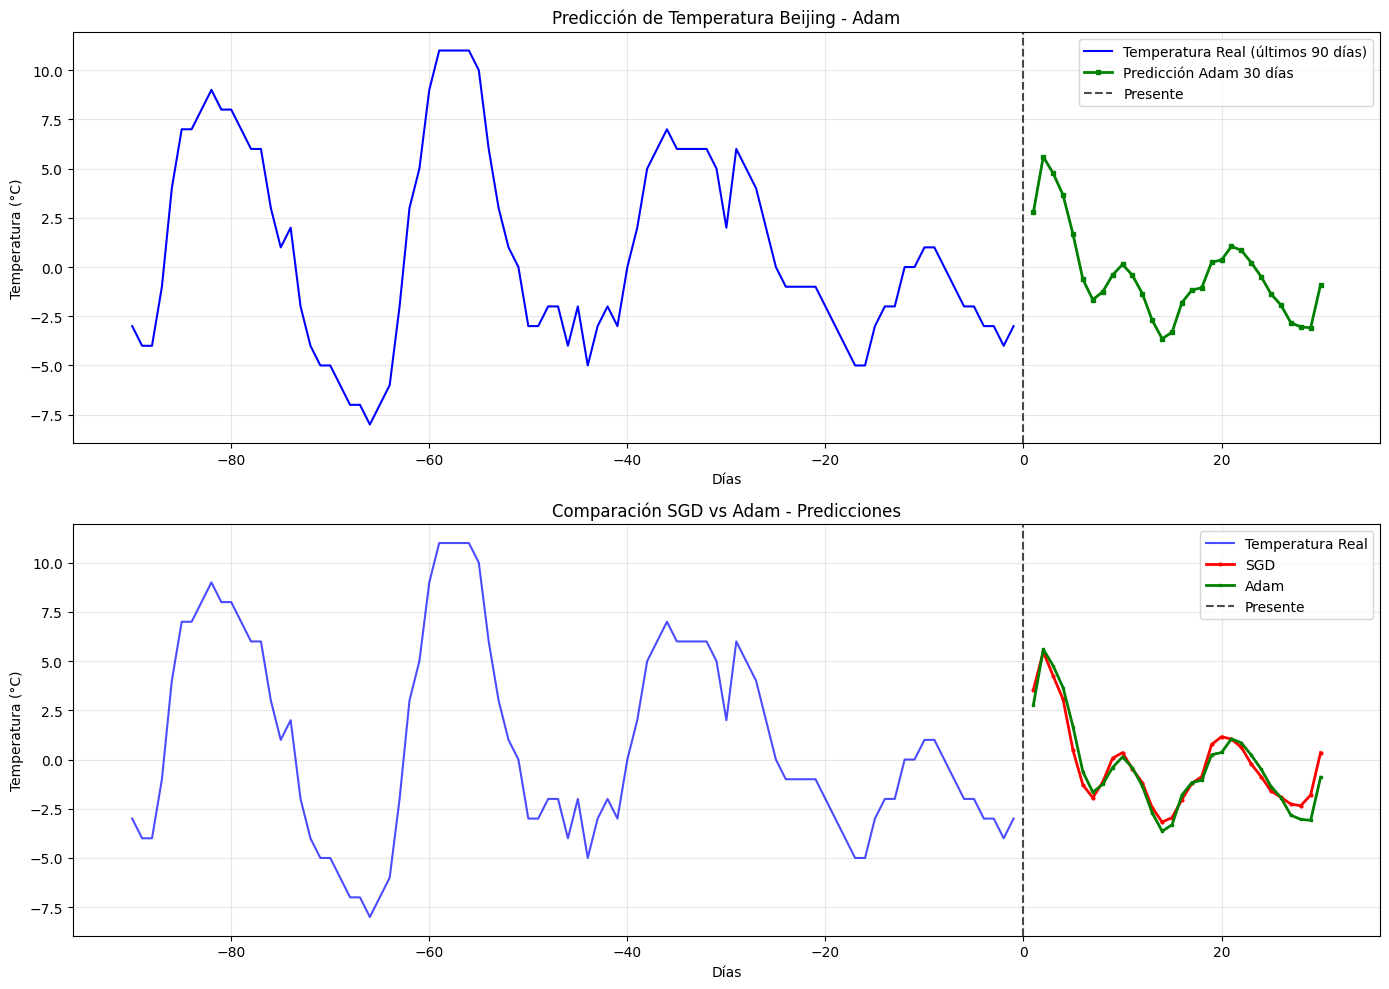


COMPARACIÓN FINAL:
SGD  - MAE: 1.1220°C | Precisión: 92.0%
Adam - MAE: 0.9235°C | Precisión: 93.4%

Primeras predicciones:
SGD:  3.55°C
Adam: 2.78°C
Real: -3.00°C


In [ ]:
# 14. VISUALIZACIÓN FINAL ADAM Y COMPARACIÓN

# CREAR FIGURA GRANDE PARA COMPARACIÓN COMPLETA
plt.figure(figsize=(14, 10))

# PRIMERA GRÁFICA: PREDICCIONES SOLO DE ADAM
plt.subplot(2, 1, 1)
# Temperaturas históricas en azul
plt.plot(historical_indices, historical_temp, 'b-', 
         label='Temperatura Real (últimos 90 días)', linewidth=1.5)
# Predicciones Adam en verde con marcadores cuadrados
plt.plot(prediction_indices, predictions_30_days_adam, 'g-', 
         label='Predicción Adam 30 días', linewidth=2, marker='s', markersize=3)
# Línea divisoria del presente
plt.axvline(x=0, color='black', linestyle='--', alpha=0.7, label='Presente')

plt.xlabel('Días')
plt.ylabel('Temperatura (°C)')
plt.title('Predicción de Temperatura Beijing - Adam')
plt.legend()
plt.grid(True, alpha=0.3)

# SEGUNDA GRÁFICA: COMPARACIÓN DIRECTA SGD vs ADAM
plt.subplot(2, 1, 2)
# Datos históricos (más transparentes para enfocar en predicciones)
plt.plot(historical_indices, historical_temp, 'b-', 
         label='Temperatura Real', linewidth=1.5, alpha=0.7)
# Predicciones SGD en rojo con círculos
plt.plot(prediction_indices, predictions_30_days, 'r-', 
         label='SGD', linewidth=2, marker='o', markersize=2)
# Predicciones Adam en verde con cuadrados
plt.plot(prediction_indices, predictions_30_days_adam, 'g-', 
         label='Adam', linewidth=2, marker='s', markersize=2)
# Línea divisoria
plt.axvline(x=0, color='black', linestyle='--', alpha=0.7, label='Presente')

plt.xlabel('Días')
plt.ylabel('Temperatura (°C)')
plt.title('Comparación SGD vs Adam - Predicciones')
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()  # Ajustar espaciado entre gráficas
plt.show()

# COMPARACIÓN NUMÉRICA FINAL
print("\nCOMPARACIÓN FINAL:")
print("=" * 50)
# Mostrar métricas lado a lado para comparación fácil
print(f"SGD  - MAE: {best_result['mae']:.4f}°C | Precisión: {best_result['precision']:.1f}%")
print(f"Adam - MAE: {result_adam['mae']:.4f}°C | Precisión: {result_adam['precision']:.1f}%")

print("\nPrimeras predicciones:")
print(f"SGD:  {predictions_30_days[0]:.2f}°C")      # Primera predicción SGD
print(f"Adam: {predictions_30_days_adam[0]:.2f}°C")  # Primera predicción Adam
print(f"Real: {y[-1]:.2f}°C")                       # Último valor real para referencia